## 0. Imports and Global Configuration

In [3]:
import random
import numpy as np
from pathlib import Path
import torch

#* Global Constants
PROJECT_ROOT = Path().resolve()
print("Project root:", PROJECT_ROOT)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Random Seed
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)		
torch.manual_seed(RANDOM_STATE)

# Data Split Config
TEST_SIZE = 0.20   # 20% test
VAL_SIZE = 0.10    # 10% val (of the whole)

# Image Config
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0  # adjust as needed based on OS/CPU

# Paths
IMAGE_ROOTS = [
    Path("./data/soil_images/Orignal-Dataset"),
    Path("./data/soil_images/CyAUG-Dataset"),
]

CHECKPOINT_DIR = Path("./artifacts")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
CKPT_PATH = CHECKPOINT_DIR / "best_resnet_soil.pth"

# Normalization stats (ImageNet)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

Project root: E:\STUDY\temp\RS\Project\crop-rs
Device: cpu


## 1. Data Preparation (Images)

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

def build_image_dataframe(roots):
    # Scans the provided root directories for images and creates a DataFrame.
    # Returns a DataFrame with columns: filepath, label, source.
    image_paths = []
    for root in roots:
        if not root.exists():
            print(f"Warning: {root} does not exist.")
            continue
        # Gather all files in subdirectories
        image_paths.extend(root.glob("*/*"))

    if not image_paths:
        raise FileNotFoundError(f"No images found under {roots}. Check paths.")

    records = []
    for path in image_paths:
        # folder name = soil type (label)
        soil_label = path.parent.name
        # parent folder = dataset source
        dataset_source = path.parent.parent.name
        
        records.append((str(path), soil_label, dataset_source))

    df = pd.DataFrame(records, columns=["filepath", "label", "source"])
    return df

def split_dataset(df, test_size, val_size, random_state, print_all=False):
    # Splits the dataframe into train, validation, and test sets (stratified).
    # Returns (train_df, val_df, test_df).
    
    # 1. Split off TEST from (train+val)
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df["label"],
        random_state=random_state,
    )

    # 2. Split train_val into TRAIN and VAL
    # Adjust val_size to be relative to the train_val portion
    val_rel_size = val_size / (1 - test_size)

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_rel_size,
        stratify=train_val_df["label"],
        random_state=random_state,
    )
    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)} \n")
    if print_all:
        print(train_df["label"].value_counts())
        print(val_df["label"].value_counts())
        print(test_df["label"].value_counts())
    
    return train_df, val_df, test_df
# --- Execution ---

# 1. Build DataFrame
df = build_image_dataframe(IMAGE_ROOTS)
print(f"Total images: {len(df)}")
print("Label counts:\n", df["label"].value_counts(), "\n")

# 2. Split Data
train_df, val_df, test_df = split_dataset(df, TEST_SIZE, VAL_SIZE, RANDOM_STATE, True)

# 3. Class Mapping
class_names = sorted(df["label"].unique())
class_to_idx = {cls: i for i, cls in enumerate(class_names)}
idx_to_class = {i: cls for cls, i in class_to_idx.items()}
num_classes = len(class_names)

print("Class mapping:", class_to_idx)

Total images: 6286
Label counts:
 label
Yellow_Soil      1470
Black_Soil       1428
Red_Soil         1235
Alluvial_Soil     745
Arid_Soil         568
Laterite_Soil     438
Mountain_Soil     402
Name: count, dtype: int64 

Train: 4399, Val: 629, Test: 1258 

label
Yellow_Soil      1029
Black_Soil        999
Red_Soil          864
Alluvial_Soil     522
Arid_Soil         397
Laterite_Soil     306
Mountain_Soil     282
Name: count, dtype: int64
label
Yellow_Soil      147
Black_Soil       143
Red_Soil         124
Alluvial_Soil     74
Arid_Soil         57
Laterite_Soil     44
Mountain_Soil     40
Name: count, dtype: int64
label
Yellow_Soil      294
Black_Soil       286
Red_Soil         247
Alluvial_Soil    149
Arid_Soil        114
Laterite_Soil     88
Mountain_Soil     80
Name: count, dtype: int64
Class mapping: {'Alluvial_Soil': 0, 'Arid_Soil': 1, 'Black_Soil': 2, 'Laterite_Soil': 3, 'Mountain_Soil': 4, 'Red_Soil': 5, 'Yellow_Soil': 6}


## 2. Dataset & DataLoaders

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# --- Transforms ---
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# --- Dataset Class ---
class SoilDataset(Dataset):
    # Custom Dataset for loading soil images from a pandas DataFrame.
    def __init__(self, dataframe, class_to_idx, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filepath = row["filepath"]
        label_name = row["label"]
        
        label = self.class_to_idx[label_name]
        image = Image.open(filepath).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

def create_dataloaders(train_df, val_df, test_df, class_to_idx, batch_size, num_workers, display=False):
    # Creates DataLoaders for train, val, and test sets.
    train_ds = SoilDataset(train_df, class_to_idx, transform=train_transform)
    val_ds   = SoilDataset(val_df,   class_to_idx, transform=val_test_transform)
    test_ds  = SoilDataset(test_df,  class_to_idx, transform=val_test_transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    if display:
        print("Classes in the training dataset:")
        from torchvision.datasets import ImageFolder
        soil_train_dataset = ImageFolder(root=IMAGE_ROOTS[0], transform=train_transform)
        print(soil_train_dataset.classes, "\n")

    return train_loader, val_loader, test_loader

# --- Execution ---
train_loader, val_loader, test_loader = create_dataloaders(
    train_df, val_df, test_df, class_to_idx, BATCH_SIZE, NUM_WORKERS, display=True
)
print(f"Batches: Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)}")

Classes in the training dataset:
['Alluvial_Soil', 'Arid_Soil', 'Black_Soil', 'Laterite_Soil', 'Mountain_Soil', 'Red_Soil', 'Yellow_Soil'] 

Batches: Train=138, Val=20, Test=40


## 3. Model Definition & Training

In [6]:
import time
from copy import deepcopy
from torch import nn, optim
from torchvision import models

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, save_path=None):
    # Trains the model and saves the best checkpoint based on validation accuracy.
    # Returns the model with best weights loaded.
    
    best_model_wts = deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        start = time.time()
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # ----- TRAIN -----
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double().item() / len(train_loader.dataset)

        # ----- VALIDATION -----
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double().item() / len(val_loader.dataset)

        elapsed = time.time() - start
        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f} (Time: {elapsed:.1f}s)")

        # Save best weights
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())
            if save_path:
                torch.save(best_model_wts, save_path)
                print("  --> Best model updated and saved to", save_path)

    print(f"\nBest val accuracy: {best_val_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

# --- Execution ---

# 1. Define Model
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
in_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(in_features, num_classes)
resnet50 = resnet50.to(device)

# 2. Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=1e-3)

# 3. Train or Load
if CKPT_PATH.exists():
    resnet50.load_state_dict(torch.load(CKPT_PATH, map_location=device))
    print("Loaded ResNet50 checkpoint from", CKPT_PATH)
else:
    resnet50 = train_model(
        resnet50, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        num_epochs=20, 
        save_path=CKPT_PATH
    )

Loaded ResNet50 checkpoint from artifacts\best_resnet_soil.pth


## 4. Evaluation

Classification report:

               precision    recall  f1-score   support

Alluvial_Soil       1.00      0.40      0.57       149
    Arid_Soil       0.58      0.95      0.72       114
   Black_Soil       0.99      0.97      0.98       286
Laterite_Soil       0.81      0.90      0.85        88
Mountain_Soil       0.75      0.96      0.84        80
     Red_Soil       0.98      0.97      0.97       247
  Yellow_Soil       0.94      0.92      0.93       294

     accuracy                           0.88      1258
    macro avg       0.86      0.86      0.84      1258
 weighted avg       0.91      0.88      0.88      1258



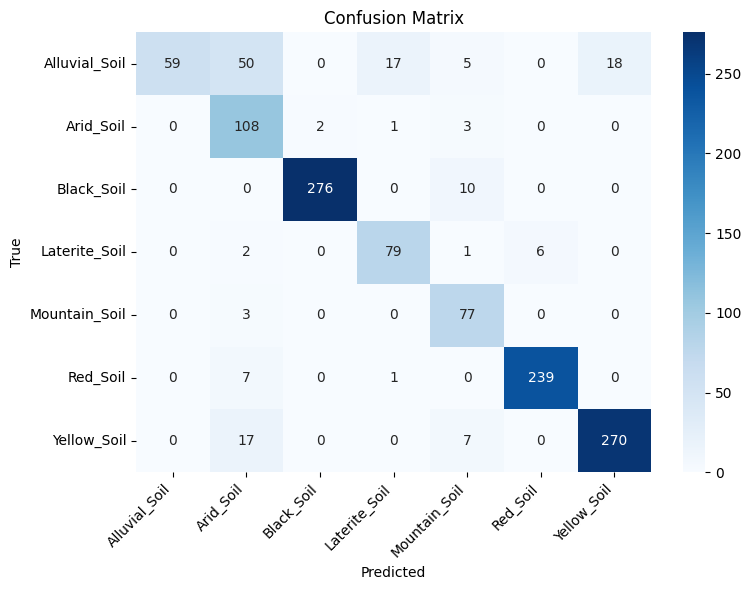

[[ 59  50   0  17   5   0  18]
 [  0 108   2   1   3   0   0]
 [  0   0 276   0  10   0   0]
 [  0   2   0  79   1   6   0]
 [  0   3   0   0  77   0   0]
 [  0   7   0   1   0 239   0]
 [  0  17   0   0   7   0 270]]


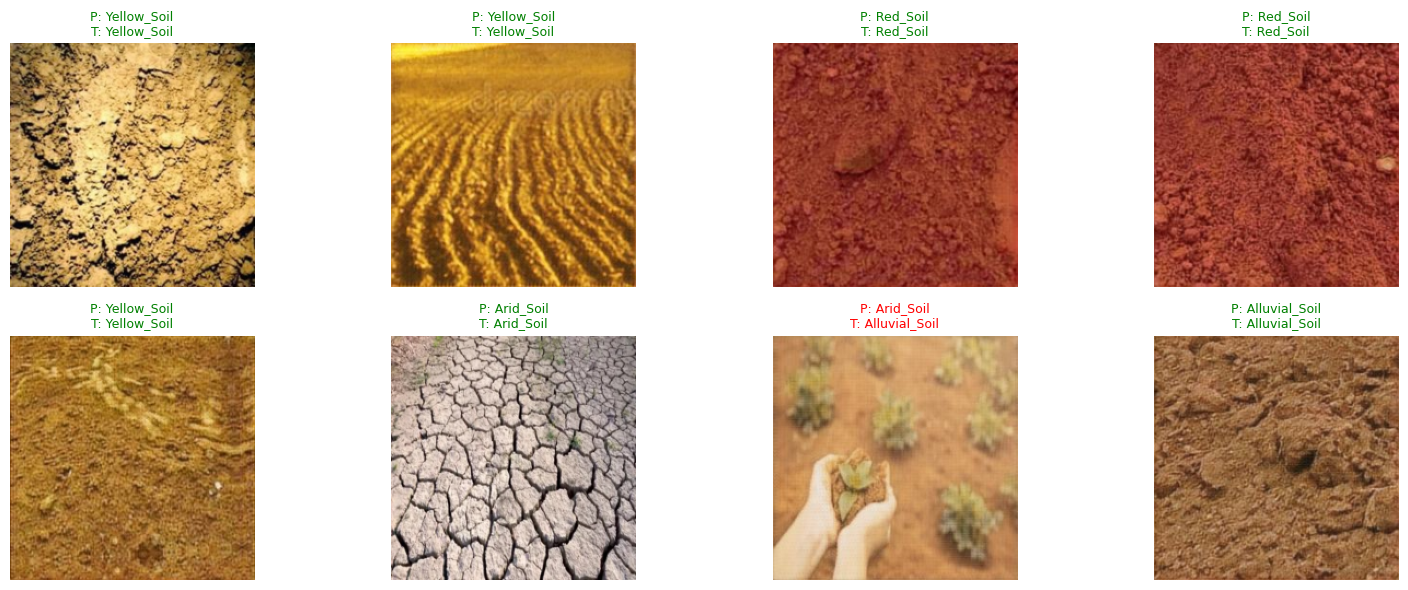

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def collect_predictions(model, loader, device):
    # Runs inference on the loader and returns all true labels and predictions.
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            
    return all_labels, all_preds

def plot_confusion_matrix(y_true, y_pred, class_names):
    # Plots a heatmap of the confusion matrix.
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=class_names, yticklabels=class_names,
        cmap="Blues"
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    print(cm)

def unnormalize_image(img_tensor):
    # Converts a normalized tensor image back to numpy [0,1] range.
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = np.array(IMAGENET_STD) * img + np.array(IMAGENET_MEAN)
    img = np.clip(img, 0, 1)
    return img

def plot_predictions_grid(model, loader, idx_to_class, device, num_images=8):
    # Plots a grid of random predictions from a single batch.
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
    indices = random.sample(range(len(images)), min(num_images, len(images)))
    N = len(indices)
    
    _, axes = plt.subplots(2, (N + 1) // 2, figsize=(16, 6))
    axes = axes.flatten()
    
    for j, i in enumerate(indices):
        img = unnormalize_image(images[i])
        true_label = idx_to_class[labels[i].item()]
        pred_label = idx_to_class[preds[i].item()]
        
        ax = axes[j]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"P: {pred_label}\nT: {true_label}",
                     color=("green" if pred_label == true_label else "red"),
                     fontsize=9)
    
    # Hide unused axes
    for k in range(j+1, len(axes)):
        axes[k].axis("off")
        
    plt.tight_layout()
    plt.show()

# --- Execution ---

# 1. Metrics
all_labels, all_preds = collect_predictions(resnet50, test_loader, device)
print("Classification report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# 2. Confusion Matrix
plot_confusion_matrix(all_labels, all_preds, class_names)

# 3. Visual Grid
plot_predictions_grid(resnet50, test_loader, idx_to_class, device)

## 5. Crop Recommendation (Tabular + XGBoost)

In [12]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from torch.utils.data import Dataset, DataLoader

# --- Tabular Dataset Class ---
class CropDataset(Dataset):
    # Dataset for tabular crop data.
    # X: Features (numpy array)
    # y: Labels (numpy array)
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --- Helper Functions ---

def load_and_preprocess_crop_data(csv_path, soil_class_names):
    # Loads crop data, simulates soil type using IMAGE CLASSES, and preprocesses features
    df = pd.read_csv(csv_path)
    
    # Simulate soil type using the actual class names from the image dataset
    # ensuring consistency between image predictions and tabular features
    np.random.seed(42)
    df['soil_type'] = np.random.choice(soil_class_names, size=len(df))
    
    # One-hot encode soil_type
    # We use pd.Categorical to ensure the columns are created in a deterministic order 
    # matching the provided class_names list
    df['soil_type'] = pd.Categorical(df['soil_type'], categories=soil_class_names)
    soil_dummies = pd.get_dummies(df['soil_type'], prefix='soil')
    
    # Save the feature names for inference alignment
    soil_feature_names = soil_dummies.columns.tolist()
    
    df = pd.concat([df.drop('soil_type', axis=1), soil_dummies], axis=1)
    
    # Separate X and y
    X = df.drop('label', axis=1).values
    y = df['label'].values
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Standardize numerical features (first 7 columns)
    # Assumption: Columns 0-6 are [N, P, K, temperature, humidity, ph, rainfall]
    scaler = StandardScaler()
    X_num = scaler.fit_transform(X[:, :7])
    X_cat = X[:, 7:]
    
    X_final = np.concatenate([X_num, X_cat], axis=1).astype(np.float32)
    
    return X_final, y_encoded, le, scaler, soil_feature_names

def train_xgb_model(X_train, y_train):
    # Trains an XGBoost classifier.
    model = xgb.XGBClassifier(
        use_label_encoder=False, 
        eval_metric='mlogloss', 
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

def evaluate_xgb(model, X_test, y_test):
    # Evaluates the XGBoost model.
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("XGBoost Test Accuracy: {:.2f}%".format(acc * 100))

# --- Execution ---

# 1. Load & Preprocess (Passing class_names from Section 1)
if 'class_names' not in locals():
    # Fallback if running out of order, though ideally should run sequentially
    print("Warning: class_names not found, using default placeholder.")
    class_names = ['Alluvial_Soil', 'Black_Soil', 'Clay_Soil', 'Red_Soil']

X_final, y_encoded, label_encoder, scaler, soil_feature_names = load_and_preprocess_crop_data('./data/tabular/d1.csv', class_names)
print("Feature shape:", X_final.shape)
print("Classes:", label_encoder.classes_)
print("Soil Features:", soil_feature_names)

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_encoded, test_size=0.2, random_state=42)

# 3. Train XGBoost
xgb_model = train_xgb_model(X_train, y_train)

# 4. Evaluate
evaluate_xgb(xgb_model, X_test, y_test)

# 5. (Optional) PyTorch DataLoaders for Tabular
TABULAR_BATCH_SIZE = 32
train_ds_tab = CropDataset(X_train, y_train)
test_ds_tab = CropDataset(X_test, y_test)
train_loader_tab = DataLoader(train_ds_tab, batch_size=TABULAR_BATCH_SIZE, shuffle=True)
test_loader_tab = DataLoader(test_ds_tab, batch_size=TABULAR_BATCH_SIZE, shuffle=False)

Feature shape: (2200, 14)
Classes: ['apple' 'banana' 'blackgram' 'chickpea' 'coconut' 'coffee' 'cotton'
 'grapes' 'jute' 'kidneybeans' 'lentil' 'maize' 'mango' 'mothbeans'
 'mungbean' 'muskmelon' 'orange' 'papaya' 'pigeonpeas' 'pomegranate'
 'rice' 'watermelon']
Soil Features: ['soil_Alluvial_Soil', 'soil_Arid_Soil', 'soil_Black_Soil', 'soil_Laterite_Soil', 'soil_Mountain_Soil', 'soil_Red_Soil', 'soil_Yellow_Soil']


c:\Users\Saad\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:35:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Test Accuracy: 98.64%


## 6. Integrated Pipeline

----- Running Integrated Pipeline Tests -----

Test Case: Strongly acidic (pH=3.7) with adequate nutrients, expected: Not suitable
=> Using Rule-based Recommendations:
Predicted Soil Type: Mountain_Soil
Rule-based Recommended Crop(s): ['Not suitable for any crop']
=> Using XGBoost Recommendations:
Predicted Soil Type: Mountain_Soil
Rule-based Recommended Crop(s): ['Not suitable for any crop']
=> Using XGBoost Recommendations:
Predicted Soil Type: Mountain_Soil
XGBoost Recommended Crop: rice

Test Case: Highly alkaline (pH=8.0) with adequate nutrients, expected: Not suitable
=> Using Rule-based Recommendations:
Predicted Soil Type: Mountain_Soil
XGBoost Recommended Crop: rice

Test Case: Highly alkaline (pH=8.0) with adequate nutrients, expected: Not suitable
=> Using Rule-based Recommendations:
Predicted Soil Type: Mountain_Soil
Rule-based Recommended Crop(s): ['Not suitable for any crop']
=> Using XGBoost Recommendations:
Predicted Soil Type: Mountain_Soil
Rule-based Recommended Crop(

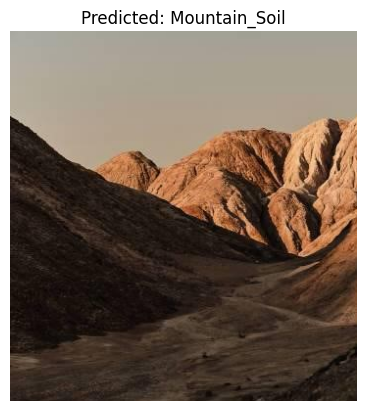

In [19]:
from PIL import Image
import matplotlib.pyplot as plt

#* Helper Functions

def predict_soil_type(image_path, model, transform, device):
    # Predicts the soil type index from an image path.
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()

def predict_crop_with_xgb(numerical_values, soil_label_idx, soil_classes, xgb_model, scaler, label_encoder, soil_feature_names):
    # Predicts crop using XGBoost model with consistent soil encoding.
    # numerical_values: shape (1, 7) = [N, P, K, temperature, humidity, pH, rainfall] 
    
    # 1. Scale numerical features
    X_num = scaler.transform(numerical_values)
    
    # 2. Create One-Hot Soil Vector
    # soil_classes is idx_to_class dict {0: 'Alluvial', ...}
    soil_name = soil_classes[soil_label_idx]
    
    # Create zero vector of length equal to soil features
    soil_vector = np.zeros((1, len(soil_feature_names)), dtype=np.float32)
    
    # Find which column corresponds to this soil name
    # Feature name format is "soil_<Name>"
    target_col = f"soil_{soil_name}"
    
    if target_col in soil_feature_names:
        idx = soil_feature_names.index(target_col)
        soil_vector[0, idx] = 1.0
    else:
        print(f"Warning: Soil type {soil_name} not found in tabular training features.")
        
    # 3. Concatenate
    X_input = np.concatenate([X_num, soil_vector], axis=1)
    
    # 4. Predict
    pred_idx = xgb_model.predict(X_input)[0]
    crop_name = label_encoder.inverse_transform([pred_idx])[0]
    
    return crop_name

def rule_based_crop_recommendation(soil_numerical_values, soil_label, soil_classes):
    # Returns recommended crops based on soil nutrients and type.
    # soil_numerical_values: [N, P, K, temperature, humidity, pH, rainfall]
    
    # Extract key values
    N = soil_numerical_values[0, 0]
    P = soil_numerical_values[0, 1]
    K = soil_numerical_values[0, 2]
    pH = soil_numerical_values[0, 5]
    
    # Rule: pH limits
    if pH < 4.0 or pH > 7.5:
        return ["Not suitable for any crop"]
    
    # Rule: Nutrient deficiency
    if N < 50 or P < 20 or K < 20:
        return ["Nutrients deficient - not suitable for any crop"]
    
    # Rule: Soil Type Specifics
    soil_type = soil_classes[soil_label]
    recommendations = []
    
    if soil_type == "Alluvial_Soil":
        recommendations = ["Rice"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Sugarcane")
            
    elif soil_type == "Black_Soil":
        recommendations = ["Maize"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Cotton")
            
    elif soil_type == "Clay_Soil":
        recommendations = ["Wheat"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Barley")
            
    elif soil_type == "Red_Soil":
        recommendations = ["Vegetables"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Pulses")
            
    else:
        recommendations = ["Crop recommendation unclear"]
    
    return recommendations

def integrated_pipeline(soil_image_path, soil_numerical_values, model, transform, soil_classes, device, 
                       override_soil_label=None, use_xgb=False, 
                       xgb_model=None, scaler=None, label_encoder=None, soil_feature_names=None):
    # End-to-end pipeline: Image -> Soil Type -> Rules/XGB -> Crop Recommendation.
    
    # 1. Determine Soil Type
    if override_soil_label is None:
        soil_label = predict_soil_type(soil_image_path, model, transform, device)
        soil_type_name = soil_classes[soil_label]
        print(f"Predicted Soil Type: {soil_type_name}")
    else:
        soil_label = override_soil_label
        soil_type_name = soil_classes[soil_label]
        print(f"Predicted Soil Type (Override): {soil_type_name}")
    
    
    # 2. Get Recommendations
    if use_xgb:
        if any(x is None for x in [xgb_model, scaler, label_encoder, soil_feature_names]):
             print("Error: XGBoost model components missing. Falling back to rules.")
             recommended_crops = rule_based_crop_recommendation(soil_numerical_values, soil_label, soil_classes)
        else:
            rec = predict_crop_with_xgb(soil_numerical_values, soil_label, soil_classes, xgb_model, scaler, label_encoder, soil_feature_names)
            recommended_crops = [rec]
            print(f"XGBoost Recommended Crop: {rec}")
    else:
        recommended_crops = rule_based_crop_recommendation(soil_numerical_values, soil_label, soil_classes)
        print(f"Rule-based Recommended Crop(s): {recommended_crops}")
    
    return recommended_crops

#* Test Cases

test_cases = [
    {
        "name": "Strongly acidic (pH=3.7) with adequate nutrients, expected: Not suitable",
        "numerical": np.array([[90, 40, 40, 20, 80, 3.7, 200]]),
        "override": None
    },
    {
        "name": "Highly alkaline (pH=8.0) with adequate nutrients, expected: Not suitable",
        "numerical": np.array([[90, 40, 40, 25, 70, 8.0, 150]]),
        "override": None
    },
    {
        "name": "Nutrient deficient (N=40) at neutral pH (6.5), expected: Nutrients deficient",
        "numerical": np.array([[40, 40, 40, 20, 80, 6.5, 200]]),
        "override": None
    },
    {
        "name": "Optimal conditions for Alluvial soil with high nutrients, expected: Rice and Sugarcane",
        "numerical": np.array([[120, 60, 60, 22, 75, 6.5, 180]]),
        "override": None
    },
    {
        "name": "Optimal conditions for Black Soil with high nutrients, expected: Maize and Cotton",
        "numerical": np.array([[120, 60, 60, 23, 80, 6.5, 170]]),
        "override": None
    },
    {
        "name": "Optimal conditions for Clay soil with high nutrients, expected: Wheat and Barley",
        "numerical": np.array([[120, 60, 60, 20, 85, 6.5, 160]]),
        "override": None
    },
    {
        "name": "Optimal conditions for Red soil with high nutrients, expected: Vegetables and Pulses",
        "numerical": np.array([[120, 60, 60, 21, 80, 6.5, 190]]),
        "override": None
    }
]

# --- Execution ---
print("----- Running Integrated Pipeline Tests -----")

# Pick a random sample image for testing
sample_image_path = test_df.sample(1)['filepath'].iloc[0]
soil_classes = idx_to_class # using the dict we created earlier

for case in test_cases:
    print(f"\nTest Case: {case['name']}")
    
    # 1. Run with Rules
    print("=> Using Rule-based Recommendations:")
    integrated_pipeline(
        sample_image_path, 
        case["numerical"], 
        resnet50, 
        val_test_transform, 
        soil_classes, 
        device, 
        override_soil_label=case["override"],
        use_xgb=False
    )
    
    # 2. Run with XGBoost (if available)
    if 'xgb_model' in locals():
        print("=> Using XGBoost Recommendations:")
        integrated_pipeline(
            sample_image_path, 
            case["numerical"], 
            resnet50, 
            val_test_transform, 
            soil_classes, 
            device, 
            override_soil_label=case["override"],
            use_xgb=True,
            xgb_model=xgb_model,
            scaler=scaler,
            label_encoder=label_encoder,
            soil_feature_names=soil_feature_names
        )

# Visualize
print("\nVisualizing Sample:")
pred_idx = predict_soil_type(sample_image_path, resnet50, val_test_transform, device)
plt.imshow(Image.open(sample_image_path))
plt.title(f"Predicted: {soil_classes[pred_idx]}")
plt.axis("off")
plt.show()